# What types of vehicles are on NYC roadways?


## Introduction

Before constructing a measure for NYC vehicle activity, we would like to consider the different classes (auto, bus, taxi, trucks, etc.) of vehicles on NYC's roads. Knowing the breakdown of vehicular traffic by class would allow one to weight the importance of a data sources related to a single vehicle class. For example bus data would not be a great measure of vehicle activity in NYC if it represents a small percentage of traffic. 

Fortunately, the NYC Department of Transporation (DOT) conducted a series of vehicle classification counts for New York Metropolitan Transportation Council (NYMTC) at various locations throughout NYC to determine the breakdown of traffic by vehicle class. 

### Loading modules

In [45]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

### Settings

In [46]:
pd.options.display.min_rows =30
pd.options.display.max_rows =40
pd.options.display.width = 120

### Helper Functions

In [47]:
def distribution_stats(series):
    """Return pd.Series of distribution stats for input series"""
    stats = {
        "count": series.count(),
        "min": series.min(),
        "1%": series.quantile(0.01),
        "5%": series.quantile(0.05),
        "25%": series.quantile(0.25),
        "50%": series.quantile(0.50),
        "75%": series.quantile(0.75),
        "95%": series.quantile(0.95),
        "99%": series.quantile(0.99),
        "max": series.max(),
        "median": series.median(),
        "mean": series.mean(),
        "median absolute deviation ": scipy.stats.median_absolute_deviation(series),
        "standard deviation": series.std(),
        "skew": series.skew(),
        "kurtosis": series.kurtosis(),
    }
    stats = pd.DataFrame.from_dict(stats, orient="index", columns=["Stat Value"])
    return stats


def frequency_table(series):
    """Return pd.Series frequency table for input series"""
    freq = series.value_counts()
    freq.name = "Count"
    percent = series.value_counts(normalize=True) * 100
    percent = pd.Series(["{0:.2f}%".format(x) for x in percent], index=percent.index)
    percent.name = "% of total"
    output = pd.concat([freq, percent], axis=1)
    output.index = [abbreviate_string(x, limit=60) for x in output.index]
    return output


def abbreviate_string(s, limit=60):
    if isinstance(s, str):
        return s[:limit]
    else:
        return s



### Loading data

Recent vehicle classification data can be found at:
- https://data.cityofnewyork.us/Transportation/Vehicle-Classification-Counts-2014-2018-/96ay-ea4r

or directly downloaded with an API key from:
- https://data.cityofnewyork.us/resource/96ay-ea4r.csv

Pandas will be used to load the data from csv to a Pandas DataFrame (DF)

In [48]:
vehicle_class = pd.read_csv("data/vehicle/vehicle classification/Vehicle_Classification_Counts__2014-2018_.csv")

### Exploring Data

**Inspecting data dimensions and data type**

In [49]:
vehicle_class.shape

(8771, 32)

In [50]:
vehicle_class.dtypes

ID                  int64
SegmentID           int64
Roadway Name       object
From               object
To                 object
Direction          object
Date               object
Veh Class Type     object
12:00-1:00 AM     float64
1:00-2:00AM       float64
2:00-3:00AM       float64
3:00-4:00AM       float64
4:00-5:00AM       float64
5:00-6:00AM       float64
6:00-7:00AM       float64
7:00-8:00AM       float64
8:00-9:00AM       float64
9:00-10:00AM      float64
10:00-11:00AM     float64
11:00-12:00PM     float64
12:00-1:00PM      float64
1:00-2:00PM       float64
2:00-3:00PM       float64
3:00-4:00PM       float64
4:00-5:00PM       float64
5:00-6:00PM       float64
6:00-7:00PM       float64
7:00-8:00PM       float64
8:00-9:00PM       float64
9:00-10:00PM      float64
10:00-11:00PM     float64
11:00-12:00AM     float64
dtype: object

**Checking DF for duplicates**


In [51]:
vehicle_class.duplicated(keep=False).sum()

0

**Checking for null values**

There seems to be a relatively consistent number of null values for the distinct time slots. 

In [52]:
vehicle_class.isna().sum()

ID                   0
SegmentID            0
Roadway Name         0
From                 0
To                   0
Direction            0
Date                 0
Veh Class Type       0
12:00-1:00 AM     3276
1:00-2:00AM       3276
2:00-3:00AM       3276
3:00-4:00AM       3276
4:00-5:00AM       3276
5:00-6:00AM       3276
6:00-7:00AM       3276
7:00-8:00AM       3276
8:00-9:00AM       3276
9:00-10:00AM      3325
10:00-11:00AM     3276
11:00-12:00PM     3276
12:00-1:00PM      3290
1:00-2:00PM       3276
2:00-3:00PM       3276
3:00-4:00PM       3276
4:00-5:00PM       3276
5:00-6:00PM       3276
6:00-7:00PM       3276
7:00-8:00PM       3276
8:00-9:00PM       3304
9:00-10:00PM      3276
10:00-11:00PM     3276
11:00-12:00AM     3276
dtype: int64

Examining a sample set of observations, we can see that per-column nulls in one row are matched by values in the other row. Since the 24 hours of observation were split up over two days, the data appears in two rows. Hours with no observations were not recored as 0, resulting in a "NaN" when pandas parsed the csv file. 

In [53]:
vehicle_class[
    (vehicle_class["Roadway Name"] == "34 Avenue")
    & (vehicle_class["From"] == "113 Street")
    & (vehicle_class["Veh Class Type"] == "Auto")
    & (vehicle_class["Direction"] == "EB")
]

,ID,SegmentID,Roadway Name,From,To,Direction,Date,Veh Class Type,12:00-1:00 AM,1:00-2:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
14,1,152030,34 Avenue,113 Street,114 Street,EB,10/29/2014,Auto,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,273.0,202.0,156.0,133.0
21,1,152030,34 Avenue,113 Street,114 Street,EB,10/30/2014,Auto,69.0,38.0,...,482.0,355.0,330.0,432.0,444.0,361.0,NaN,NaN,NaN,NaN


**Checking to see if data is representative of NYC**

Unfortunately Borough (county) and road type were not included to verify that the data is a reasonable representation of vehicle types on NYC roads. We can use 'Roadway Name" and the "From' and "To" crossstreets with knowledge of NYC to verify that the data is at least a reasonable sample. All five boroughs on NYC are represented in the traffic studies. Furthermore the traffic studies contain samples from different types of roadways such as highways, major bridges, and smaller local roads.

In [54]:
vehicle_class["Location"] = (
    vehicle_class["Roadway Name"]
    + " FROM "
    + vehicle_class["From"]
    + " TO "
    + vehicle_class["To"]
)

frequency_table(vehicle_class['Location'])

,Count,% of total
WILLIAMSBURG BRIDGE FROM MANHATTAN TO BROOKLYN,56,0.64%
EAST 167 STREET FROM WALTON AVENUE TO GRANDVIEW PLACE,56,0.64%
1st Avenue FROM 47 Street TO 48 Street,56,0.64%
EAST 167 STREET FROM SHERMAN AVENUE TO SHERIDAN AVENUE,56,0.64%
FDR Drive FROM 28 Street TO 29 Street,42,0.48%
13 AVENUE FROM 72 STREET TO 73 STREET,28,0.32%
Belt Parkway FROM Erskine Street TO Pennsylvania Avenue,28,0.32%
East 233 Street FROM Webster Avenue TO Bronx River Parkway,28,0.32%
48 Street FROM Northern Boulevard TO 37 Avenue,28,0.32%
Sanford Avenue FROM 147 Street TO 149 Street,28,0.32%


**Number of sets of observations**

A single set of observations is recorded as 7 rows, 1 row for each class of vehicle. We can see that there are a total of 1253 sets of observations and that they seem complete.

In [55]:
frequency_table(vehicle_class['Veh Class Type'])

,Count,% of total
Auto,1253,14.29%
Taxis,1253,14.29%
Medium Truck,1253,14.29%
Commercial,1253,14.29%
Heavy Truck,1253,14.29%
School Bus,1253,14.29%
Other Bus,1253,14.29%


**Date Range**

We can verify that the observations occured from 2014 to 2018

In [56]:
vehicle_class['datetime'] = pd.to_datetime(vehicle_class['Date'], format="%m/%d/%Y")
vehicle_class['datetime'].min()


Timestamp('2014-09-16 00:00:00')

In [57]:
vehicle_class['datetime'].max()

Timestamp('2018-03-29 00:00:00')

**Checking and Cleaning Vehicle Counts**

Currently vehicle counts by vehicle type are reported under columns representing distinct one hour time slots. We are trying to assess the overall breakdown of vehicles on NYC roads, so we can aggregate these columns and check the distribution of counts.

In [58]:
counts = [
    "12:00-1:00 AM",
    "1:00-2:00AM",
    "2:00-3:00AM",
    "3:00-4:00AM",
    "4:00-5:00AM",
    "5:00-6:00AM",
    "6:00-7:00AM",
    "7:00-8:00AM",
    "8:00-9:00AM",
    "9:00-10:00AM",
    "10:00-11:00AM",
    "11:00-12:00PM",
    "12:00-1:00PM",
    "1:00-2:00PM",
    "2:00-3:00PM",
    "3:00-4:00PM",
    "4:00-5:00PM",
    "5:00-6:00PM",
    "6:00-7:00PM",
    "7:00-8:00PM",
    "8:00-9:00PM",
    "9:00-10:00PM",
    "10:00-11:00PM",
    "11:00-12:00AM",
]

vehicle_class["Vehicle Count"] = vehicle_class[counts].sum(axis=1)
distribution_stats(vehicle_class["Vehicle Count"])

,Stat Value
count,8771.000000
min,0.000000
1%,0.000000
5%,0.000000
25%,14.000000
50%,85.000000
75%,414.500000
95%,5872.500000
99%,26020.800000
max,104974.000000


**Checking vehicle counts for possibly erroneous outliers**

Lets examine the max vehicle count to see if it is possibly an error. 

In [59]:
vehicle_class[vehicle_class['Vehicle Count'] == 104974]

vehicle_class[
    (
        vehicle_class["Location"]
        == "Grand Central Parkway FROM 90 Street TO Ditmars Boulevard"
    )
    & (vehicle_class["Veh Class Type"] == "Auto")
]


,ID,SegmentID,Roadway Name,From,To,Direction,Date,Veh Class Type,12:00-1:00 AM,1:00-2:00AM,...,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,Location,datetime,Vehicle Count
2957,108,9012331,Grand Central Parkway,90 Street,Ditmars Boulevard,WB,11/06/2014,Auto,1327.0,685.0,...,5175.0,5227.0,5104.0,4417.0,4220.0,3731.0,2714.0,Grand Central Parkway FROM 90 Street TO Ditmar...,2014-11-06,101469.0
2964,108,9012329,Grand Central Parkway,90 Street,Ditmars Boulevard,EB,11/06/2014,Auto,1662.0,936.0,...,8293.0,7798.0,6720.0,5979.0,5144.0,4436.0,2998.0,Grand Central Parkway FROM 90 Street TO Ditmar...,2014-11-06,104974.0


The Grand Central Parkway is a heavily-trafficed major highway. The 90th and Ditmars location puts it right in front of LaGuardia Airport. Given multiple lanes (3-4), up to 10000 vehicles an hour per direction is reasonable and not likely a data entry error. 

**Calculating breakdown of NYC traffic by vehicle class**

In [60]:
counts_by_class = (
    vehicle_class["Vehicle Count"].groupby(vehicle_class["Veh Class Type"]).sum()
)
counts_by_class

Veh Class Type
Auto            9295519.0
Commercial       594099.0
Heavy Truck      127167.0
Medium Truck     306993.0
Other Bus        141026.0
School Bus        97111.0
Taxis           1252437.0
Name: Vehicle Count, dtype: float64

**Total vehicles counted = 11,814,352**

In [61]:
counts_by_class.sum()

11814352.0

**Table View of Vehicles by Class**

In [62]:
count_percentage = (counts_by_class * 100) / vehicle_class["Vehicle Count"].sum()
count_percentage.index = counts_by_class.index
count_percentage.sort_values(ascending=False, inplace=True)
type_percentage = pd.Series(
    ["{0:.2f}%".format(x) for x in count_percentage], index=count_percentage.index
)

type_percentage

Veh Class Type
Auto            78.68%
Taxis           10.60%
Commercial       5.03%
Medium Truck     2.60%
Other Bus        1.19%
Heavy Truck      1.08%
School Bus       0.82%
dtype: object

**A bar chart reinforces the predominance of passensger cars**

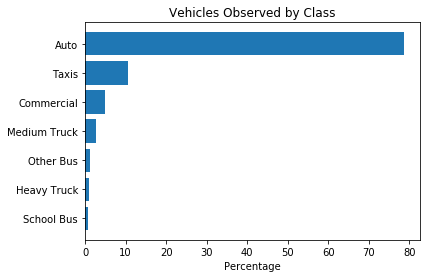

In [63]:
fig, ax = plt.subplots()
veh_classes = count_percentage.index
y_pos = range(len(veh_classes))
percentage = count_percentage.values
ax.barh(y_pos, percentage, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(veh_classes)
ax.invert_yaxis()
ax.set_xlabel('Percentage')
ax.set_title('Vehicles Observed by Class')
plt.show()

## Conclusion

The DOT dataset on vehicle class contains 1253 sets of observations over three and a half years and counted 11.8 million vehicles in all five bouroughs. The data represents different types of roadways (highway, bridge, local roads, etc.) **Since the data represent vehicles actively driving, the counts are a reasonable estimate of the how much each vehicle class contributes to total miles driven in NYC**. The data shows that:
- Autos represent ~80% of vehicular traffic
- Taxis (which may not include rideshares) represent ~10% of traffic
- Other heavier vehicles represent ~10% of traffic

**An appropriate measure of traffic levels should reflect the above breakdown and not over-index on one source of information like Taxi and Limousine Commission (TLC) trips datasets.** 